In [3]:
import numpy as np
from itertools import combinations, chain, permutations, product
import xcover

In [4]:
def convert_state_to_set(state):
    return set(np.nonzero(state.flatten())[0])

def get_minimal_state(state):
    axii = state.ndim
    for axis in range(axii):
        while 1 not in np.take(state, indices=[0], axis=axis):
            state = np.roll(state, -1, axis=axis)
    return state

def get_unique_arrays(array_list):
    # Convert arrays to tuples for hashability
    array_tuples = [tuple(arr.flatten()) for arr in array_list]
    
    # Create dictionary to maintain order and remove duplicates
    unique_dict = dict.fromkeys(array_tuples)
    
    # Convert back to numpy arrays while preserving original shapes
    unique_arrays = [np.array(arr).reshape(array_list[array_tuples.index(arr)].shape) 
                    for arr in unique_dict]
    
    return unique_arrays


def calc_all_rotations(state):
    """
    Generate all 90-degree rotations of an n-dimensional numpy array along all axes and their combinations.
    
    Parameters:
        array (np.ndarray): An n-dimensional numpy array.
        
    Returns:
        list of np.ndarray: A list of numpy arrays, each representing a unique rotation.
    """
    if state.ndim < 2:
        raise ValueError("The array must have at least 2 dimensions for meaningful rotations.")

    # Store all unique rotations
    rotations = []

    # Generate all possible axes permutations
    axes_permutations = list(permutations(range(state.ndim)))

    # Generate all possible 90-degree rotations for each permutation
    for axes in axes_permutations:
        for angles in product((0, 90, 180, 270), repeat=len(axes)):
            rotated = state.copy()
            for i, angle in enumerate(angles):
                if angle != 0:
                    k = angle // 90  # Number of 90-degree rotations
                    rotated = np.rot90(rotated, k=k, axes=(axes[i], axes[(i + 1) % len(axes)]))
            if not any(np.array_equal(rotated, r) for r in rotations):
                rotations.append(rotated)
    
    return rotations


def calc_all_rolls(state, axis):
    states = []
    while 1 not in np.take(state, indices=[state.shape[axis] - 1], axis=axis):
        state = np.roll(state, 1, axis=axis)
        states.append(state)
    return states

def calc_all_states(state):
    """With rolls and rotations"""
    axii = state.ndim
    states = []
    rotations = calc_all_rotations(state)
    for rot in rotations:
        rot = get_minimal_state(rot)
        rolls = []
        rolls.append(rot)
        for axis in range(axii):
            axis_rolls = []
            for roll in rolls:
                axis_rolls += calc_all_rolls(roll, axis)
            rolls += axis_rolls
        states += rolls
    return get_unique_arrays(states)

def solve_packing(states, amounts, verbose=False):
    state_idxs = []
    state_rolls_rotations = []
    state_idxs.append(0)
    for state in states:
        state_rolls_rotations += calc_all_states(state)
        state_idxs.append(len(state_rolls_rotations))

    state_sets = []
    for state in state_rolls_rotations:
        state_sets.append(convert_state_to_set(state))
    if (verbose):
        print(f"State sets len={len(state_sets)}:")
        print(state_sets)

    
    solutions = list(xcover.covers([list(s) for s in state_sets]))
    if (verbose):
        print("solutions:")
        print(solutions)

    def is_valid_sol(sol):
        sol.sort()
        sol = np.array(sol)
        for i in range(len(state_idxs) - 1):
            n = np.count_nonzero((sol >= state_idxs[i]) & (sol < state_idxs[i+1]))
            if n > amounts[i]:
                return False
        return True

    valid_solutions = [s for s in solutions if is_valid_sol(s)]
    if (verbose):
        print(f"Valid solution (only 1 of each piece) len={len(valid_solutions)}: ")
        print(valid_solutions)
    
    # todo filter out solutions which are rotations of other solutions
    print(f"{len(solutions)} valid solutions found!")
    return valid_solutions, state_sets

In [5]:
# Visualize to check solutions

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D


def get_cmap(n, name='hsv'):
    '''Returns a function that maps each index in 0, 1, ..., n-1 to a distinct 
    RGB color; the keyword argument name must be a standard mpl colormap name.'''
    return plt.cm.get_cmap(name, n)

def visualize_voxels_plt(objects_voxels, lims):
    """
    Visualizes a list of voxel coordinates for multiple objects in 3D.
    
    Args:
        objects_voxels (list of list of list of tuple): Each element is a list of lists representing
                                                       voxel coordinates for one object.
                                                       Example: [[[x1, y1, z1], [x2, y2, z2], ...], ...]
    """
    fig = plt.figure()
    ax = fig.add_subplot(projection='3d')
    ax.set_xlim(0, lims[0])
    ax.set_ylim(0, lims[1])
    ax.set_zlim(0, lims[2])
    ax.set_box_aspect([1, 1, 1])  # Equal aspect ratio

    # # Generate unique colors for each object
    # colors = plt.cm.tab20(np.linspace(0, 1, len(objects_voxels)))
    cmap = get_cmap(len(objects_voxels))

    for i, voxels in enumerate(objects_voxels):
        # Unpack voxel coordinates for the object
        x_coords, y_coords, z_coords = zip(*voxels)
        
        # Define voxel array
        voxel_array = np.zeros((max(x_coords) + 1, max(y_coords) + 1, max(z_coords) + 1), dtype=bool)
        voxel_array[x_coords, y_coords, z_coords] = True
        
        # Plot voxels with corresponding color
        ax.voxels(voxel_array, facecolors=cmap(i), edgecolor='k', shade=True)

    plt.show()
    
def visualize_voxels(state_sets, unravel_tuple):
    lims = [0, 0, 0]
    lims[0] = unravel_tuple[0]
    lims[1] = unravel_tuple[1]
    if len(unravel_tuple) == 2:
        lims[2] = 1
        unravel_tuple = (unravel_tuple[0], unravel_tuple[1], 1)
    else:
        lims[2] = unravel_tuple[2]
        
    coords = [[np.unravel_index(i, unravel_tuple) for i in state_set] for state_set in state_sets]
    visualize_voxels_plt(coords, lims)
        

In [59]:
# Squares by Designer : Unknown. 
# https://puzzlewillbeplayed.com/66/Squares/
# Pieces	8 	I-L, W-Z are congruent.
# Selection	random
# Goal  	6×6×1
# Holes	    0
# Solutions	1

states = []
states.append(np.array([[1,1,1,0,0,0],[1,0,0,0,0,0],[0,0,0,0,0,0],[0,0,0,0,0,0],[0,0,0,0,0,0],[0,0,0,0,0,0]])) # Piece I..L
states.append(np.array([[1,1,0,0,0,0],[0,1,0,0,0,0],[0,1,1,0,0,0],[0,0,0,0,0,0],[0,0,0,0,0,0],[0,0,0,0,0,0]])) # Piece W..Z

solutions, state_sets = solve_packing(states=states, amounts=[4]*2)

State sets len=112:
[{0, 1, 2, 6}, {8, 12, 6, 7}, {18, 12, 13, 14}, {24, 18, 19, 20}, {24, 25, 26, 30}, {1, 2, 3, 7}, {8, 2, 3, 4}, {9, 3, 4, 5}, {8, 9, 13, 7}, {8, 9, 10, 14}, {9, 10, 11, 15}, {19, 13, 14, 15}, {16, 20, 14, 15}, {16, 17, 21, 15}, {25, 19, 20, 21}, {26, 20, 21, 22}, {27, 21, 22, 23}, {25, 26, 27, 31}, {32, 26, 27, 28}, {33, 27, 28, 29}, {0, 1, 13, 7}, {19, 13, 6, 7}, {25, 19, 12, 13}, {25, 18, 19, 31}, {8, 1, 2, 14}, {9, 2, 3, 15}, {16, 10, 3, 4}, {17, 11, 4, 5}, {8, 20, 14, 7}, {8, 9, 21, 15}, {16, 9, 10, 22}, {17, 10, 11, 23}, {26, 20, 13, 14}, {27, 21, 14, 15}, {16, 28, 22, 15}, {16, 17, 29, 23}, {32, 26, 19, 20}, {33, 27, 20, 21}, {34, 28, 21, 22}, {35, 29, 22, 23}, {8, 2, 6, 7}, {8, 12, 13, 14}, {18, 19, 20, 14}, {24, 25, 26, 20}, {32, 26, 30, 31}, {8, 9, 3, 7}, {8, 9, 10, 4}, {9, 10, 11, 5}, {9, 13, 14, 15}, {16, 10, 14, 15}, {16, 17, 11, 15}, {19, 20, 21, 15}, {16, 20, 21, 22}, {17, 21, 22, 23}, {25, 26, 27, 21}, {26, 27, 28, 22}, {27, 28, 29, 23}, {32, 33, 27, 

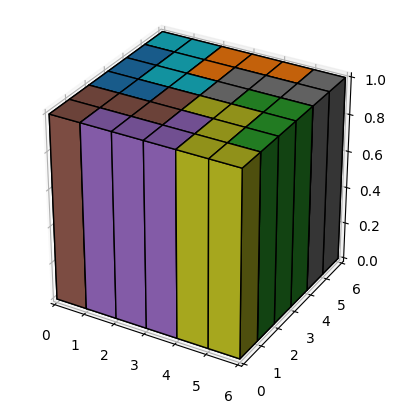

In [60]:
visualize_voxels([state_sets[i] for i in solutions[0]], (6,6))

In [61]:
# Symmetric Hexa-Square by 小田原充宏 (Mitsuhiro Odawara) (2004). 
# https://puzzlewillbeplayed.com/66/SymmetricHexaSquare/
# Pieces    14 	        use 6 pieces
# Selection	complete
# Goal	    6×6×1
# Holes	    0
# Solutions	1

states = []
states.append(np.array([[1,1,1,1,1,0],[0,0,1,0,0,0],[0,0,0,0,0,0],[0,0,0,0,0,0],[0,0,0,0,0,0],[0,0,0,0,0,0]])) # Piece A
states.append(np.array([[1,1,1,1,0,0],[1,0,0,1,0,0],[0,0,0,0,0,0],[0,0,0,0,0,0],[0,0,0,0,0,0],[0,0,0,0,0,0]])) # Piece B
states.append(np.array([[1,1,1,1,0,0],[0,1,1,0,0,0],[0,0,0,0,0,0],[0,0,0,0,0,0],[0,0,0,0,0,0],[0,0,0,0,0,0]])) # Piece C
states.append(np.array([[1,1,1,0,0,0],[1,1,1,0,0,0],[0,0,0,0,0,0],[0,0,0,0,0,0],[0,0,0,0,0,0],[0,0,0,0,0,0]])) # Piece D
states.append(np.array([[1,1,1,0,0,0],[1,1,0,0,0,0],[1,0,0,0,0,0],[0,0,0,0,0,0],[0,0,0,0,0,0],[0,0,0,0,0,0]])) # Piece E
states.append(np.array([[1,1,1,0,0,0],[0,1,1,1,0,0],[0,0,0,0,0,0],[0,0,0,0,0,0],[0,0,0,0,0,0],[0,0,0,0,0,0]])) # Piece F
states.append(np.array([[1,1,1,0,0,0],[0,0,1,1,1,0],[0,0,0,0,0,0],[0,0,0,0,0,0],[0,0,0,0,0,0],[0,0,0,0,0,0]])) # Piece G
states.append(np.array([[1,1,0,0,0,0],[1,1,1,0,0,0],[0,1,0,0,0,0],[0,0,0,0,0,0],[0,0,0,0,0,0],[0,0,0,0,0,0]])) # Piece H
states.append(np.array([[1,1,0,0,0,0],[0,1,1,0,0,0],[1,1,0,0,0,0],[0,0,0,0,0,0],[0,0,0,0,0,0],[0,0,0,0,0,0]])) # Piece I
states.append(np.array([[1,1,0,0,0,0],[0,1,1,0,0,0],[0,0,1,1,0,0],[0,0,0,0,0,0],[0,0,0,0,0,0],[0,0,0,0,0,0]])) # Piece J
states.append(np.array([[1,0,0,0,0,0],[1,1,1,1,0,0],[1,0,0,0,0,0],[0,0,0,0,0,0],[0,0,0,0,0,0],[0,0,0,0,0,0]])) # Piece K
states.append(np.array([[1,0,0,0,0,0],[1,1,1,1,0,0],[0,0,0,1,0,0],[0,0,0,0,0,0],[0,0,0,0,0,0],[0,0,0,0,0,0]])) # Piece L
states.append(np.array([[0,1,0,0,0,0],[1,1,1,1,0,0],[0,1,0,0,0,0],[0,0,0,0,0,0],[0,0,0,0,0,0],[0,0,0,0,0,0]])) # Piece M
states.append(np.array([[0,1,0,0,0,0],[1,1,1,1,0,0],[0,0,1,0,0,0],[0,0,0,0,0,0],[0,0,0,0,0,0],[0,0,0,0,0,0]])) # Piece N

solutions, state_sets = solve_packing(states=states, amounts=[1]*14)

State sets len=610:
[{0, 1, 2, 3, 4, 8}, {6, 7, 8, 9, 10, 14}, {12, 13, 14, 15, 16, 20}, {18, 19, 20, 21, 22, 26}, {32, 24, 25, 26, 27, 28}, {1, 2, 3, 4, 5, 9}, {7, 8, 9, 10, 11, 15}, {13, 14, 15, 16, 17, 21}, {19, 20, 21, 22, 23, 27}, {33, 25, 26, 27, 28, 29}, {1, 7, 12, 13, 19, 25}, {7, 13, 18, 19, 25, 31}, {2, 8, 13, 14, 20, 26}, {3, 9, 14, 15, 21, 27}, {4, 10, 15, 16, 22, 28}, {5, 11, 16, 17, 23, 29}, {32, 8, 14, 19, 20, 26}, {33, 9, 15, 20, 21, 27}, {34, 10, 16, 21, 22, 28}, {35, 11, 17, 22, 23, 29}, {2, 6, 7, 8, 9, 10}, {8, 12, 13, 14, 15, 16}, {14, 18, 19, 20, 21, 22}, {20, 24, 25, 26, 27, 28}, {32, 33, 34, 26, 30, 31}, {3, 7, 8, 9, 10, 11}, {9, 13, 14, 15, 16, 17}, {15, 19, 20, 21, 22, 23}, {21, 25, 26, 27, 28, 29}, {32, 33, 34, 35, 27, 31}, {0, 6, 12, 13, 18, 24}, {6, 12, 18, 19, 24, 30}, {1, 7, 13, 14, 19, 25}, {2, 8, 14, 15, 20, 26}, {3, 9, 15, 16, 21, 27}, {4, 10, 16, 17, 22, 28}, {7, 13, 19, 20, 25, 31}, {32, 8, 14, 20, 21, 26}, {33, 9, 15, 21, 22, 27}, {34, 10, 16, 22, 23

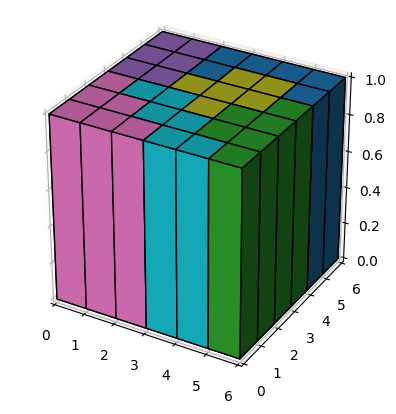

In [62]:
visualize_voxels([state_sets[i] for i in solutions[0]], (6,6))

In [6]:
# The "25Y" or "125 cube" puzzle

state = np.array([[[1,1,1,1,0],[0,1,0,0,0],[0,0,0,0,0],[0,0,0,0,0],[0,0,0,0,0]],[[0,0,0,0,0],[0,0,0,0,0],[0,0,0,0,0],[0,0,0,0,0],[0,0,0,0,0]],[[0,0,0,0,0],[0,0,0,0,0],[0,0,0,0,0],[0,0,0,0,0],[0,0,0,0,0]],[[0,0,0,0,0],[0,0,0,0,0],[0,0,0,0,0],[0,0,0,0,0],[0,0,0,0,0]],[[0,0,0,0,0],[0,0,0,0,0],[0,0,0,0,0],[0,0,0,0,0],[0,0,0,0,0]]])

solutions, state_sets = solve_packing(states=[state], amounts=[25])

60672 valid solutions found!


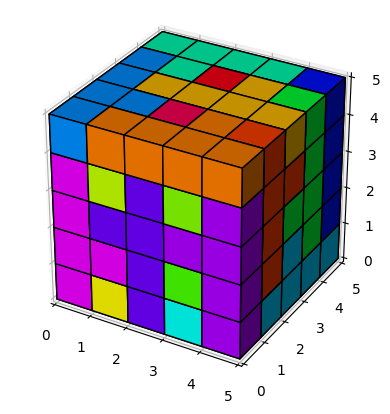

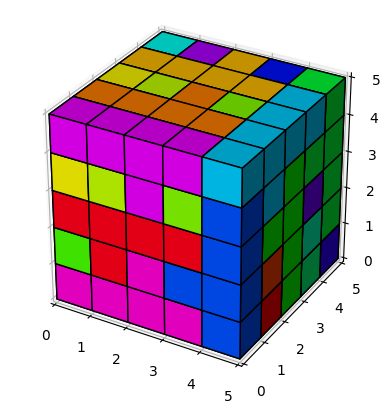

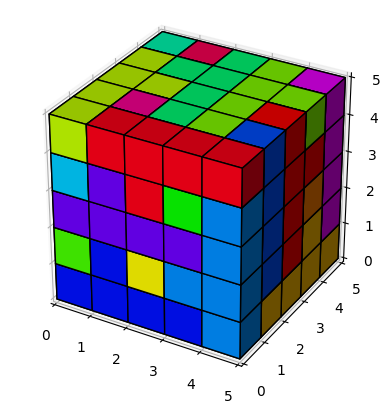

In [7]:
visualize_voxels([state_sets[i] for i in solutions[0]], (5,5,5))
visualize_voxels([state_sets[i] for i in solutions[10000]], (5,5,5))
visualize_voxels([state_sets[i] for i in solutions[20000]], (5,5,5))